In [25]:
from my_weapon import *
from tqdm import tqdm_notebook as tqdm
sns.set(style="whitegrid", font_scale=1.3)
# plt.style.use('fivethirtyeight')

# Age and gender

2019-08-04 https://pbs.twimg.com/profile_images/556652210403020801/aRwPvCTT.jpeg 



In [26]:
# loc_to_country = json.load(open("data/loc_to_country_v2"))
import unicodedata

def normalize_spanish(text):
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode().lower()

loc_to_country = json.load(open("data/loc_to_country_Google.json"))

for loc, address in loc_to_country.items():
    # print(loc, " | ", address)
    loc_to_country[loc] = address.split(", ")[-1]
    
loc_to_country["caba"] = "Argentina"


def in_Argentina(_d):
    if "location" in _d:
        loc = normalize_spanish(_d["location"])
        if '🇦🇷' in _d["location"] or "argentina" in loc or (loc in loc_to_country and loc_to_country[loc] == "Argentina"):
            return 1
        elif loc in loc_to_country:
            return 2
    return False


def outside_Argentina(_d):
    if "location" in _d:
        loc = normalize_spanish(_d["location"])
        if '🇦🇷' in _d["location"] or "argentina" in loc:
            return False
        if loc in loc_to_country and loc_to_country[loc] != "Argentina":
            return True
    return False


def get_country(_d):
    if "location" in _d:
        loc = normalize_spanish(_d["location"])
        if '🇦🇷' in _d["location"] or "argentina" in loc:
            return "Argetina"
        elif loc in loc_to_country and loc_to_country[loc] == "Argentina":
            return "Argetina"
        elif loc in loc_to_country and loc_to_country[loc] != "Argentina":
            return loc_to_country[loc]
        else:
            return "Location Not Found"
    return "No Location info"

len(loc_to_country)

124175

# One week

In [68]:
users = []

for line in tqdm(open("disk/user_profile/0731-week-image.txt")):
    d = json.loads(line.strip())
    loc = normalize_spanish(d["location"])
    
    if not outside_Argentina(d):
        face = d["faces"][0]
        # print(face)
        age = face['attributes']["age"]["value"]
        gender = face['attributes']["gender"]["value"]

        if age < 16:
            continue
        elif age >= 16 and age < 30:
            age_range = ">=16, <30"
        elif age >= 30 and age < 50:
            age_range = ">=30, <50"
        elif age >= 50 and age < 65:
            age_range = ">=50, <65"
        elif age >= 65:
            age_range = ">=65"
        
        users.append({"uid": d["id"], "age": age, "gender": gender, "age_range": age_range})
        
users = pd.DataFrame(users).set_index("uid")
users = users[~users.index.duplicated(keep='first')]

In [69]:
users.groupby("gender").count()

,age,age_range
gender,,
Female,47750,47750
Male,80202,80202


In [70]:
m_15, f_15 = 0, 0
m_30, f_30 = 0, 0
m_50, f_50 = 0, 0
m_65, f_65 = 0, 0

for i, row in tqdm(users.iterrows()):
    if row.gender == "Male":
        if row.age >= 16 and row.age < 30:
            m_15 += 1
        elif row.age >= 30 and row.age < 50:
            m_30 += 1
        elif row.age >= 50 and row.age < 65:
            m_50 += 1
        elif row.age >= 65:
            m_65 += 1
    elif row.gender == "Female":
        if row.age >= 16 and row.age < 30:
            f_15 += 1
        elif row.age >= 30 and row.age < 50:
            f_30 += 1
        elif row.age >= 50 and row.age < 65:
            f_50 += 1
        elif row.age >= 65:
            f_65 += 1
            
age_gender_dist = {
    "category": [
        "female 16-29", "male 16-29", 
        "female 30-49", "male 30-49", 
        "female 50-64", "male 50-64", 
        "female >=65", "male >=65",
    ],
    "n": [
          f_15, m_15, 
          f_30, m_30, 
          f_50, m_50, 
          f_65, m_65,
         ]
}
age_gender_dist = pd.DataFrame(age_gender_dist).set_index("category")
age_gender_dist["percent"] = age_gender_dist / age_gender_dist.sum()

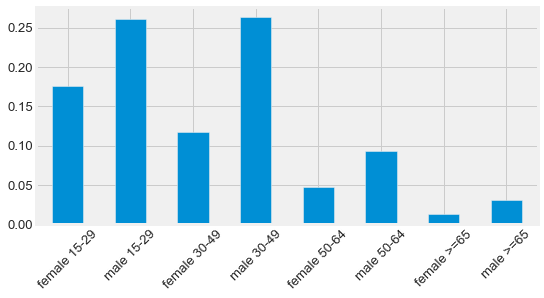

In [7]:
# age_gender_dist['n'].plot.bar(legend=None, color="r")
# plt.title("Distribtuion of population from Twitter")
plt.figure(figsize=(8, 4))
age_gender_dist["percent"].plot.bar(legend=None)
plt.xticks(rotation=45)
plt.xlabel("")
plt.savefig("web/static/population_twitter.png", dpi=300, bbox_inches = 'tight')

In [71]:
# opinion_tweets = json.load(open("disk/data/2019-07-31-without-Cristina.txt"))
# opinion_tweets = json.load(open("disk/data/2019-07-31-without-elecciones.txt"))
# opinion_tweets = json.load(open("disk/data/2019-07-31-without-both.txt"))
# opinion_tweets = json.load(open("disk/data/2019-07-31.txt"))

# opinion_tweets = json.load(open("disk/data/2019-07-31-terms1.txt"))
# opinion_tweets = json.load(open("disk/data/2019-07-31-terms2.txt"))

opinion_tweets = json.load(open("disk/data/2019-08-08/supporters_.75_7-20190731.json"))
len(opinion_tweets)

287328

In [72]:
users_opinion = []

for uid, v in opinion_tweets.items():
    if v["I"] > 0:
        continue
    if v["M"] > v["K"]:
        users_opinion.append({"uid": int(uid), "opinion": "M"})
    elif v["M"] < v["K"]:
        users_opinion.append({"uid": int(uid), "opinion": "K"})
    else:
        users_opinion.append({"uid": int(uid), "opinion": "U"})

uK_users = json.load(open("disk/data/uK_users.json"))
for uid in uK_users:
    users_opinion.append({"uid": int(uid), "opinion": "K"})
print("N of undecided users for K:", len(uK_users))

uM_users = json.load(open("disk/data/uM_users.json"))
for uid in uM_users:
    users_opinion.append({"uid": int(uid), "opinion": "M"})
print("N of undecided users for M:", len(uM_users), "\n")

users_opinion = pd.DataFrame(users_opinion).set_index("uid")
print("N of classified users:", len(users_opinion))
print("% of users supporting K:", float(users_opinion[users_opinion["opinion"] == "K"].count() / users_opinion.count()) * 100)
print()
users_v2 = users.join(users_opinion, how="inner")
print("N of classified users with age, gender in Argentina:", len(users_v2))
print("% of users supporting K:", len(users_v2[users_v2["opinion"] == "K"]) / len(users_v2) * 100)

N of undecided users for K: 27575
N of undecided users for M: 13538 

N of classified users: 316902
% of users supporting K: 37.48098781326719

N of classified users with age, gender in Argentina: 91840
% of users supporting K: 39.66354529616724


## Before adding undecided ...
N of classified users: 193397

% of users supporting K: 47.15843575650088

N of classified users with age, gender in Argentina: 45686

% of users supporting K: 49.32802171343519

---

## After adding undecided ...
N of undecided users for K: 27575

N of undecided users for M: 13538 

N of classified users: 234510

% of users supporting K: 50.64943925632169

N of classified users with age, gender in Argentina: 54621

% of users supporting K: 52.42855312059464

In [73]:
groups = users_v2.groupby(["age_range", "gender", "opinion"]).size()
groups

age_range  gender  opinion
>=16, <30  Female  K          8881
                   M          5054
                   U          5244
           Male    K          8619
                   M          7551
                   U          6541
>=30, <50  Female  K          4642
                   M          4142
                   U          2563
           Male    K          8299
                   M          8257
                   U          5236
>=50, <65  Female  K          1723
                   M          2387
                   U           935
           Male    K          2865
                   M          3441
                   U          1527
>=65       Female  K           418
                   M           632
                   U           188
           Male    K           980
                   M          1240
                   U           475
dtype: int64

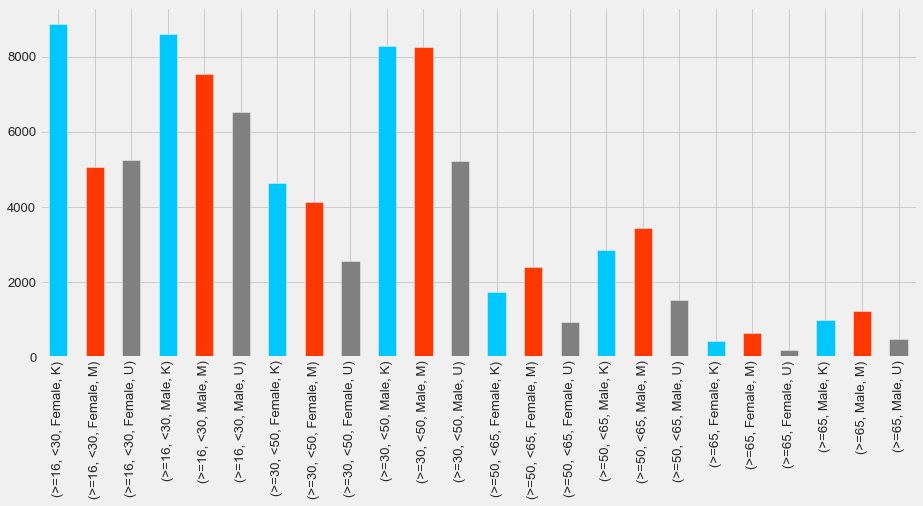

In [74]:
Kc = "#00c8ff";
Mc = "#ff3700";
sns.set(style="darkgrid", font_scale=1.2)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 6))
groups.plot.bar(color=[Kc, Mc, "grey"])
plt.xlabel("")
plt.savefig("web/static/different_users_week-2.png", bbox_inches = 'tight', dpi=300)

In [619]:
print(">=15, <30, Female & Male")
groups[">=15, <30"]["Female"]["K"] / sum(groups[">=15, <30"]["Female"]), groups[">=15, <30"]["Male"]["K"] / sum(groups[">=15, <30"]["Male"])

>=15, <30, Female & Male


(0.6344846591952967, 0.5225708340003201)

In [620]:
print(">=30, <50, Female & Male")
groups[">=30, <50"]["Female"]["K"] / sum(groups[">=30, <50"]["Female"]), groups[">=30, <50"]["Male"]["K"] / sum(groups[">=30, <50"]["Male"])

>=30, <50, Female & Male


(0.5289400787286777, 0.4962674714104193)

In [621]:
print(">=50, <65, Female & Male")
groups[">=50, <65"]["Female"]["K"] / sum(groups[">=50, <65"]["Female"]), groups[">=50, <65"]["Male"]["K"] / sum(groups[">=50, <65"]["Male"])

>=50, <65, Female & Male


(0.4179377669310555, 0.4492417860151643)

In [622]:
print(">=65, Female & Male")
groups[">=65"]["Female"]["K"] / sum(groups[">=65"]["Female"]), groups[">=65"]["Male"]["K"] / sum(groups[">=65"]["Male"])

>=65, Female & Male


(0.3929440389294404, 0.4422724496029322)

In [623]:
"""
From census
female 15-29    0.167
female 30-49    0.176
female 50-64    0.097
female >=65     0.081

male 15-29      0.167
male 30-49      0.168
male 50-64      0.088
male >=65       0.056
"""
print("After reweighting!")
+ groups[">=15, <30"]["Female"]["K"] / sum(groups[">=15, <30"]["Female"]) * 0.167 \
+ groups[">=15, <30"]["Male"]["K"] / sum(groups[">=15, <30"]["Male"]) * 0.167 \
+ groups[">=30, <50"]["Female"]["K"] / sum(groups[">=30, <50"]["Female"]) * 0.176 \
+ groups[">=30, <50"]["Male"]["K"] / sum(groups[">=30, <50"]["Male"]) * 0.168 \
+ groups[">=50, <65"]["Female"]["K"] / sum(groups[">=50, <65"]["Female"]) * 0.097 \
+ groups[">=50, <65"]["Male"]["K"] / sum(groups[">=50, <65"]["Male"]) * 0.088 \
+ groups[">=65"]["Female"]["K"] / sum(groups[">=65"]["Female"]) * 0.081 \
+ groups[">=65"]["Male"]["K"] / sum(groups[">=65"]["Male"]) * 0.056 \

After reweighting!


0.5063636213095615

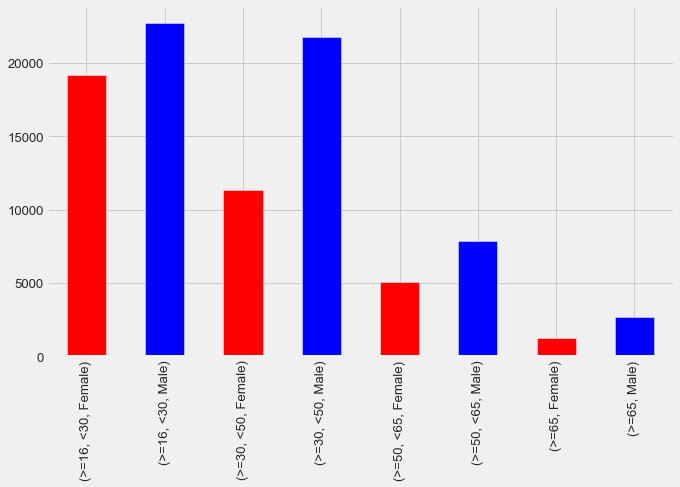

In [75]:
groups = users_v2.groupby(["age_range", "gender"]).size()
groups

sns.set(style="darkgrid", font_scale=1.2)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
groups.plot.bar(color=["red", "blue"])
plt.xlabel("")
plt.savefig("web/static/population_week-1.png", bbox_inches = 'tight', dpi=300)

In [ ]:
users[(users["age_range"] == ">=15, <30") & (users["gender"] == "Female")]

Text(0, 0.5, 'Number')

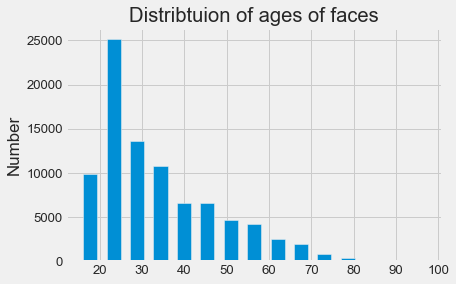

In [648]:
users.age.hist(bins=15, rwidth=0.6)
plt.title("Distribtuion of ages of faces")
plt.ylabel("Number")

In [471]:
ages[ages < 20].count() / ages.count()

0.0520322734568169

In [473]:
age_gender_dist

,n,percent
category,,
male 15-29,60111,0.261936
male 30-49,60389,0.263148
male 50-64,21139,0.092114
male >=65,6904,0.030084
female 15-29,40979,0.178568
female 30-49,26621,0.116002
female 50-64,10592,0.046155
female >=65,2752,0.011992


In [639]:
cen = {
    "age": ["15-19","20-24","25-29","30-34","35-39",
            "40-44","45-49","50-54","55-59","60-64",
            "65-69","70-74","75-79",">=80"],
    "n": [3542067, 3300149, 3130509, 3098713, 2678435,
            2310775, 2196350, 2042993, 1868950, 1621190,
            1293061, 1015897, 801660, 994030]
}

Text(0.5, 1.0, 'Age distribution from census')

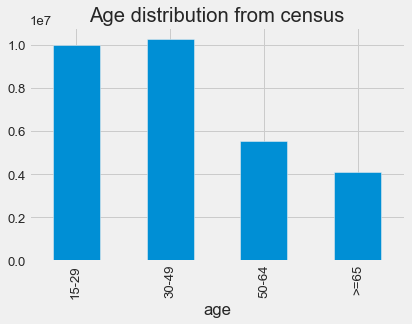

In [640]:
cen_2 = {
    "age": ["15-29", "30-49", "50-64", ">=65"],
    "n": [sum(cen["n"][: 3]), sum(cen["n"][3: 7]), sum(cen["n"][7: 10]),  sum(cen["n"][10:])]
}
cen_2 = pd.DataFrame(cen_2).set_index("age")
cen_2.plot.bar(legend=None)
plt.title("Age distribution from census")

In [641]:
cen_2["percent"] = cen_2 / cen_2.sum()

Text(0.5, 1.0, 'Age distribution from census')

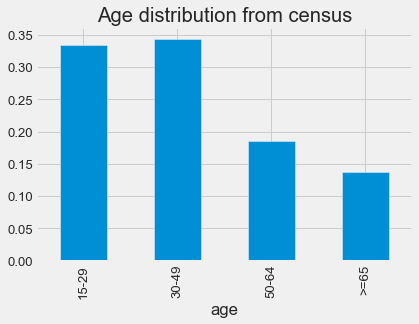

In [642]:
cen_2["percent"].plot.bar(legend=None)
plt.title("Age distribution from census")

In [643]:
cen_2

,n,percent
age,,
15-29,9972725,0.333594
30-49,10284273,0.344016
50-64,5533133,0.185087
>=65,4104648,0.137303


Age distribution: https://www.statista.com/statistics/283119/age-distribution-of-global-twitter-users/

Text(0.5, 1.0, 'Age distribution from census')

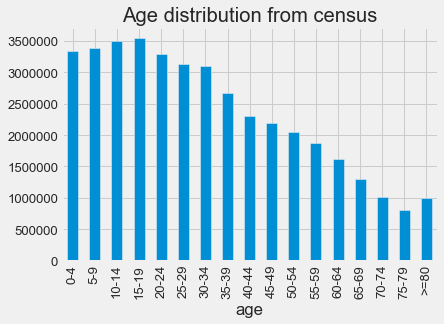

In [636]:
cen = {
    "age": ["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39","40-44",
            "45-49","50-54","55-59","60-64","65-69","70-74","75-79",">=80"],
    "n":   [3337652, 3381219, 3503446, 3542067, 3300149, 3130509, 3098713, 2678435, 2310775, 
            2196350, 2042993, 1868950, 1621190, 1293061, 1015897, 801660, 994030]
}
cen = pd.DataFrame(cen).set_index("age")
cen.plot.bar(legend=None)
plt.title("Age distribution from census")

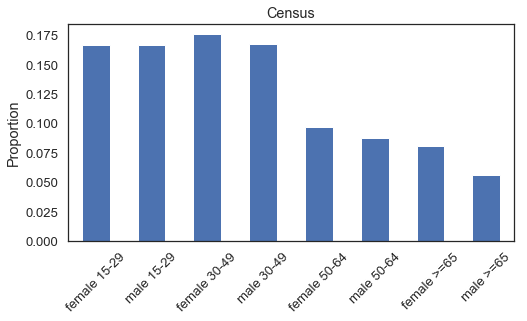

In [19]:
cen = {
    "category": ["female 15-29", "male 15-29", 
                 "female 30-49", "male 30-49", 
                 "female 50-64", "male 50-64", 
                 "female >=65", "male >=65", ],
    "n": [
          0.167, 0.167,
          0.176, 0.168,
          0.097, 0.088,
          0.081, 0.056
        ]
}
cen = pd.DataFrame(cen).set_index("category")
cen["percent"] = cen / cen.sum()

plt.figure(figsize=(8, 4))
cen["percent"].plot.bar()
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Proportion")
# plt.savefig("web/static/population_census.png", dpi=300, bbox_inches = 'tight')
plt.title("Census")
plt.savefig("fig/chart22-census.pdf", dpi=300, bbox_inches = 'tight')

In [78]:
cen["percent"]

category
male 15-29      0.167
male 30-49      0.168
male 50-64      0.088
male >=65       0.056
female 15-29    0.167
female 30-49    0.176
female 50-64    0.097
female >=65     0.081
Name: percent, dtype: float64

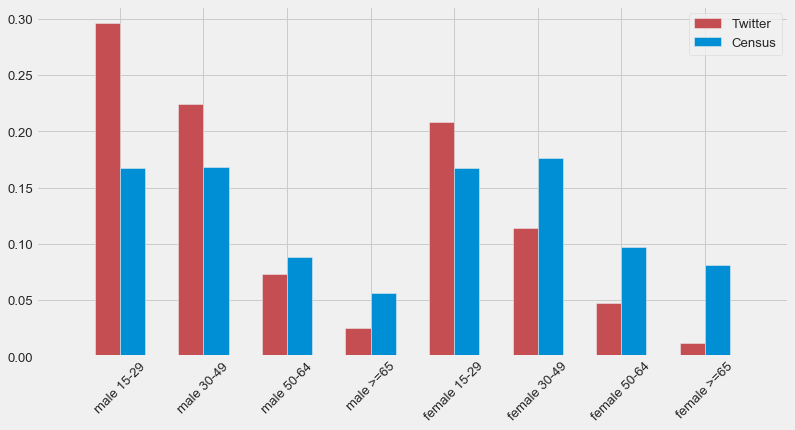

In [635]:
sns.set(style="dark", font_scale=1.2)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))
age_gender_dist["percent"].plot.bar(color="r", position=1, width=0.3, label="Twitter")
cen["percent"].plot.bar(position=0, width=0.3, label="Census")
plt.xticks(rotation=45)
plt.xlim(-1, 8)
plt.legend()
plt.xlabel("")
# plt.title("Distribtuion of population in Argentina from Twitter and Census")
plt.savefig("fig/twitter_census.png", bbox_inches = 'tight', dpi=300)

# Analyze all users before Aug.

In [ ]:
users = []

for line in tqdm(open("disk/user_profile/02-07-image.txt")):
    d = json.loads(line.strip())
    # if in_Argentina(d) == 1:
    if not outside_Argentina(d):
        face = d["faces"][0]
        # print(face)
        age = face['attributes']["age"]["value"]
        gender = face['attributes']["gender"]["value"]

#         if age < 15:
#             age_range = "<15"
        if age >= 15 and age < 30:
            age_range = ">=15, <30"
        elif age >= 30 and age < 50:
            age_range = ">=30, <50"
        elif age >= 50 and age < 65:
            age_range = ">=50, <65"
        elif age >= 65:
            age_range = ">=65"
        
        users.append({"uid": d["id"], "age": age, "gender": gender, "age_range": age_range})
        
users = pd.DataFrame(users).set_index("uid")
users = users[~users.index.duplicated(keep='first')]
len(users)

In [16]:
# users.to_pickle("disk/user_profile/02-07-users-in-Argentina-face.pl")
# users = pd.read_pickle("disk/user_profile/02-07-users-not-outsides-Argentina-face.pl")
users = pd.read_pickle("disk/user_profile/02-07-union-users.pl")

# users.head()
len(users)

635633

In [9]:
users.to_csv("disk/hernan/user-demographics.csv")

In [ ]:
dt = "2019-10-27"
opinion_tweets = json.load(open(f"disk/cul_from_March_1_v2/{dt}-0.66.txt"))
und_users = json.load(open(f"disk/homo_users/{dt}-undecided-0.66.json"))
# unc_users = json.load(open(f"disk/homo_users/{dt}-unclassified-0.66.json"))

un_FF = set(und_users["FF"])
un_MP = set(und_users["MP"])
un_UN = set(und_users["UN"])

# unc_FF = set(unc_users["FF"])
# unc_MP = set(unc_users["MP"])
# unc_UN = set(unc_users["UN"])

# un_FF = set(undecided_users["FF"]) | set(unclassified_users["FF"])
# un_MP = set(undecided_users["MP"]) | set(unclassified_users["MP"])
# un_MP = set(undecided_users["MP"]) | set(unclassified_users["MP"])

users_opinion = []

for uid, v in tqdm(opinion_tweets.items()):
    uid = int(uid)
    if v["I"] > 0:
        continue
    if v["M"] > v["K"]:
        users_opinion.append({"uid": int(uid), "opinion": "Loyal MP"})
    elif v["M"] < v["K"]:
        users_opinion.append({"uid": int(uid), "opinion": "Loyal FF"})
    elif uid in un_FF:
        users_opinion.append({"uid": int(uid), "opinion": "FF (undecided)"})
    elif uid in un_MP:
        users_opinion.append({"uid": int(uid), "opinion": "MP (undecided)"})
    elif uid in un_UN:
        users_opinion.append({"uid": int(uid), "opinion": "Undecided (undecided)"})
    elif uid in unc_FF:
        users_opinion.append({"uid": int(uid), "opinion": "FF (unclassified)"})
    elif uid in unc_MP:
        users_opinion.append({"uid": int(uid), "opinion": "MP (unclassified)"})
    elif uid in unc_UN:
        users_opinion.append({"uid": int(uid), "opinion": "Unclassified (unclassified)"})
    else:
        # print(uid, v)
        users_opinion.append({"uid": int(uid), "opinion": "Others"})
        
users_opinion = pd.DataFrame(users_opinion).set_index("uid")

In [2]:
dt = "2019-10-27"
opinion_tweets = json.load(open(f"disk/cul_from_March_1_v2/{dt}-0.66.txt"))
undecided_users = json.load(open(f"disk/homo_users/{dt}-undecided-0.66.json"))
# unclassified_users = json.load(open(f"disk/homo_users/{dt}-unclassified-0.66.json"))

un_FF = set(undecided_users["FF"])
un_MP = set(undecided_users["MP"])
# un_FF = set(undecided_users["FF"]) | set(unclassified_users["FF"])
# un_MP = set(undecided_users["MP"]) | set(unclassified_users["MP"])

users_opinion = []

for uid, v in tqdm(opinion_tweets.items()):
    if v["I"] > 0:
        continue
    if v["M"] > v["K"] or int(uid) in un_MP:
        users_opinion.append({"uid": int(uid), "opinion": "MP"})
    elif v["M"] < v["K"] or int(uid) in un_FF:
        users_opinion.append({"uid": int(uid), "opinion": "FF"})
    else:
        users_opinion.append({"uid": int(uid), "opinion": "Others"})
        
users_opinion = pd.DataFrame(users_opinion).set_index("uid")

In [21]:
# I want time series

_users_ids = {str(u) for u in users.index}

def get_users_csv(dt):
    opinion_tweets = json.load(open(f"disk/cul_from_March_1_v2/{dt.to_date_string()}-0.66.txt"))
    undecided_users = json.load(open(f"new_disk/homo_users/{dt.to_date_string()}-undecided-0.66.json"))
    # unclassified_users = json.load(open(f"disk/homo_users/{dt}-unclassified-0.66.json"))

    un_FF = set(undecided_users["FF"])
    un_MP = set(undecided_users["MP"])
    # un_FF = set(undecided_users["FF"]) | set(unclassified_users["FF"])
    # un_MP = set(undecided_users["MP"]) | set(unclassified_users["MP"])

    cnt = {
        "dt": dt.to_date_string(),
        "K": 0,
        "M": 0,
        "U": 0,
        "I": 0,
    }
    # user-level
    users_opinion = []

    for uid, v in opinion_tweets.items():
        if uid not in _users_ids or v["I"] > 0:
            continue
        if v["M"] > v["K"] or int(uid) in un_MP:
            users_opinion.append({"uid": int(uid), "opinion": "MP"})
        elif v["M"] < v["K"] or int(uid) in un_FF:
            users_opinion.append({"uid": int(uid), "opinion": "FF"})
        else:
            users_opinion.append({"uid": int(uid), "opinion": "Others"})
            
    users_opinion = pd.DataFrame(users_opinion).set_index("uid")
    users_v2 = users.join(users_opinion, how="inner")
    users_v2.to_csv(f"new_disk/user_profile_csv/MODEL3-{dt.to_date_string()}.csv")
    

start = pendulum.datetime(2019, 3, 2, tz="UTC") # include this date
end = pendulum.datetime(2019, 10, 27, tz="UTC") # not include this date

for dt in tqdm(pendulum.Period(start, end)):
    get_users_csv(dt)

In [5]:
print("N of classified users:", len(users_opinion))
print("% of users supporting K:", float(users_opinion[users_opinion["opinion"] == "FF"].count() / users_opinion.count()) * 100)
print()
users_v2 = users.join(users_opinion, how="inner")
print("N of classified users with age, gender in Argentina:", len(users_v2))
print("% of users supporting FF:", len(users_v2[users_v2["opinion"] == "FF"]) / len(users_v2) * 100)
print("% of users supporting MP:", len(users_v2[users_v2["opinion"] == "MP"]) / len(users_v2) * 100)
print("% of users supporting Others:", len(users_v2[users_v2["opinion"] == "Others"]) / len(users_v2) * 100)

print()

N of classified users: 2107468
% of users supporting K: 49.14760271567587

N of classified users with age, gender in Argentina: 329045
% of users supporting FF: 50.974182862526405
% of users supporting MP: 37.25083195307632
% of users supporting Others: 11.774985184397272



329045

In [ ]:
groups = users_v2.groupby(["age_range", "gender", "opinion"]).size()
sum(groups)

In [70]:
groups.to_excel("data/results-of-subcategories-20191011.xlsx")

In [33]:
def rescale(groups, show=False):
    """
    From census
    female 15-29    0.167
    female 30-49    0.176
    female 50-64    0.097
    female >=65     0.081

    male 15-29      0.167
    male 30-49      0.168
    male 50-64      0.088
    male >=65       0.056
    """
#     print("After rescaling:")
    reweighted_FF = groups[">=16, <30"]["Female"]["FF"] / sum(groups[">=16, <30"]["Female"]) * 0.167 \
    + groups[">=16, <30"]["Male"]["FF"] / sum(groups[">=16, <30"]["Male"]) * 0.167 \
    + groups[">=30, <50"]["Female"]["FF"] / sum(groups[">=30, <50"]["Female"]) * 0.176 \
    + groups[">=30, <50"]["Male"]["FF"] / sum(groups[">=30, <50"]["Male"]) * 0.168 \
    + groups[">=50, <65"]["Female"]["FF"] / sum(groups[">=50, <65"]["Female"]) * 0.097 \
    + groups[">=50, <65"]["Male"]["FF"] / sum(groups[">=50, <65"]["Male"]) * 0.088 \
    + groups[">=65"]["Female"]["FF"] / sum(groups[">=65"]["Female"]) * 0.081 \
    + groups[">=65"]["Male"]["FF"] / sum(groups[">=65"]["Male"]) * 0.056 \

    reweighted_MP = groups[">=16, <30"]["Female"]["MP"] / sum(groups[">=16, <30"]["Female"]) * 0.167 \
    + groups[">=16, <30"]["Male"]["MP"] / sum(groups[">=16, <30"]["Male"]) * 0.167 \
    + groups[">=30, <50"]["Female"]["MP"] / sum(groups[">=30, <50"]["Female"]) * 0.176 \
    + groups[">=30, <50"]["Male"]["MP"] / sum(groups[">=30, <50"]["Male"]) * 0.168 \
    + groups[">=50, <65"]["Female"]["MP"] / sum(groups[">=50, <65"]["Female"]) * 0.097 \
    + groups[">=50, <65"]["Male"]["MP"] / sum(groups[">=50, <65"]["Male"]) * 0.088 \
    + groups[">=65"]["Female"]["MP"] / sum(groups[">=65"]["Female"]) * 0.081 \
    + groups[">=65"]["Male"]["MP"] / sum(groups[">=65"]["Male"]) * 0.056 \

    reweighted_Others = groups[">=16, <30"]["Female"]["Others"] / sum(groups[">=16, <30"]["Female"]) * 0.167 \
    + groups[">=16, <30"]["Male"]["Others"] / sum(groups[">=16, <30"]["Male"]) * 0.167 \
    + groups[">=30, <50"]["Female"]["Others"] / sum(groups[">=30, <50"]["Female"]) * 0.176 \
    + groups[">=30, <50"]["Male"]["Others"] / sum(groups[">=30, <50"]["Male"]) * 0.168 \
    + groups[">=50, <65"]["Female"]["Others"] / sum(groups[">=50, <65"]["Female"]) * 0.097 \
    + groups[">=50, <65"]["Male"]["Others"] / sum(groups[">=50, <65"]["Male"]) * 0.088 \
    + groups[">=65"]["Female"]["Others"] / sum(groups[">=65"]["Female"]) * 0.081 \
    + groups[">=65"]["Male"]["Others"] / sum(groups[">=65"]["Male"]) * 0.056 \

    if show:
        print("% of users supporting FF:", reweighted_FF * 100)
        print("% of users supporting MP:", reweighted_MP * 100)
        print("% of users supporting 3rd party:", reweighted_Others * 100)
    
    return reweighted_FF * 100, reweighted_MP * 100, reweighted_Others * 100

In [40]:
start = pendulum.datetime(2019, 3, 2, tz="UTC") # include this date
end = pendulum.datetime(2019, 10, 27, tz="UTC") # not include this date

rsts = []
for dt in tqdm(pendulum.Period(start, end)):
    users_v2 = pd.read_csv(f"new_disk/user_profile_csv/MODEL3-{dt.to_date_string()}.csv")
    groups = users_v2.groupby(["age_range", "gender", "opinion"]).size()
    dt = dt.to_date_string()
    FF, MP, OT = rescale(groups)
    # DateTime	Fernandez (AI)	Macri (AI)	Others (AI)	Fernandez (PASO)	Macri (PASO)	Others (PASO)
    rsts.append({"dt": dt, "Fernandez (AI)": FF, "Macri (AI)": MP, "Third party (AI)": OT})
    
rsts = pd.DataFrame(rsts).set_index("dt")
rsts = rsts.round(1)
rsts["Fernandez (official)"] = 48.10
rsts["Macri (official)"] = 40.37
rsts["Third party (official)"] = 11.53

In [41]:
rsts.to_csv("data/p1-model3.csv")

In [19]:
data = pd.read_csv("web/data/2019-05-14/p-final.csv").set_index("dt")

In [20]:
data.head()

,Fernandez (AI),Macri (AI),Third party (AI),Fernandez (official),Macri (official),Third party (official)
dt,,,,,,
2019-03-02,49.5,34.2,16.3,48.1,40.37,11.53
2019-03-03,47.1,37.2,15.7,48.1,40.37,11.53
2019-03-04,40.6,43.4,15.9,48.1,40.37,11.53
2019-03-05,39.9,43.8,16.3,48.1,40.37,11.53
2019-03-06,40.3,43.4,16.3,48.1,40.37,11.53


In [23]:
data = data[["Fernandez (AI)", "Macri (AI)", "Third party (AI)"]]
data["Fernandez (official)"] = 47.8
data["Macri (official)"] = 30.8
data["Third party (official)"] = 21.4
data.to_csv("web/data/2019-05-14/p-final-2.csv")

In [24]:
data.head()

,Fernandez (AI),Macri (AI),Third party (AI),Fernandez (official),Macri (official),Third party (official)
dt,,,,,,
2019-03-02,49.5,34.2,16.3,47.8,30.8,21.4
2019-03-03,47.1,37.2,15.7,47.8,30.8,21.4
2019-03-04,40.6,43.4,15.9,47.8,30.8,21.4
2019-03-05,39.9,43.8,16.3,47.8,30.8,21.4
2019-03-06,40.3,43.4,16.3,47.8,30.8,21.4


In [71]:
"""
From census
female 15-29    0.167
female 30-49    0.176
female 50-64    0.097
female >=65     0.081

male 15-29      0.167
male 30-49      0.168
male 50-64      0.088
male >=65       0.056
"""
print("After rescaling:")
 
opinions = ["Loyal FF", "Loyal MP", 
           "FF (undecided)", "MP (undecided)", "Undecided (undecided)",
           "FF (unclassified)", "MP (unclassified)", "Unclassified (unclassified)"]

for opinion in opinions:
    reweighted_rst = groups[">=16, <30"]["Female"][opinion] / sum(groups[">=16, <30"]["Female"]) * 0.167 \
    + groups[">=16, <30"]["Male"][opinion] / sum(groups[">=16, <30"]["Male"]) * 0.167 \
    + groups[">=30, <50"]["Female"][opinion] / sum(groups[">=30, <50"]["Female"]) * 0.176 \
    + groups[">=30, <50"]["Male"][opinion] / sum(groups[">=30, <50"]["Male"]) * 0.168 \
    + groups[">=50, <65"]["Female"][opinion] / sum(groups[">=50, <65"]["Female"]) * 0.097 \
    + groups[">=50, <65"]["Male"][opinion] / sum(groups[">=50, <65"]["Male"]) * 0.088 \
    + groups[">=65"]["Female"][opinion] / sum(groups[">=65"]["Female"]) * 0.081 \
    + groups[">=65"]["Male"][opinion] / sum(groups[">=65"]["Male"]) * 0.056 \

    print(opinion, '\t', reweighted_rst)

After rescaling:
Loyal FF 	 0.4660027276101667
Loyal MP 	 0.3644810269438905
FF (undecided) 	 0.03490840204688657
MP (undecided) 	 0.018711678330244896
Undecided (undecided) 	 0.029592550396506125
FF (unclassified) 	 0.024392031903348224
MP (unclassified) 	 0.011136436360137057
Unclassified (unclassified) 	 0.050775146408819874


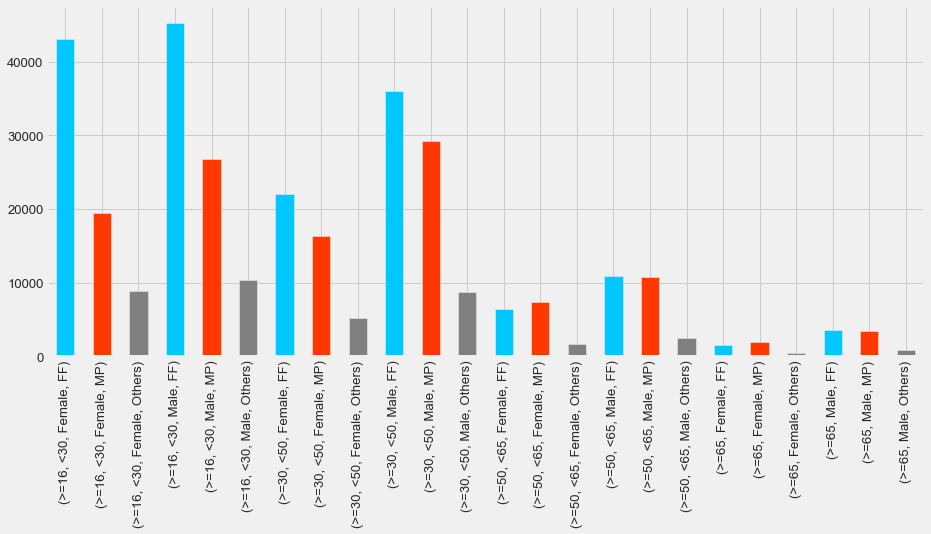

In [48]:
Kc = "#00c8ff";
Mc = "#ff3700";
sns.set(style="darkgrid", font_scale=1.2)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 6))
groups.plot.bar(color=[Kc, Mc, "grey"])
plt.xlabel("")
plt.savefig("fig/different_users-1011.png", bbox_inches = 'tight', dpi=300)

Text(0.5, 0, '')

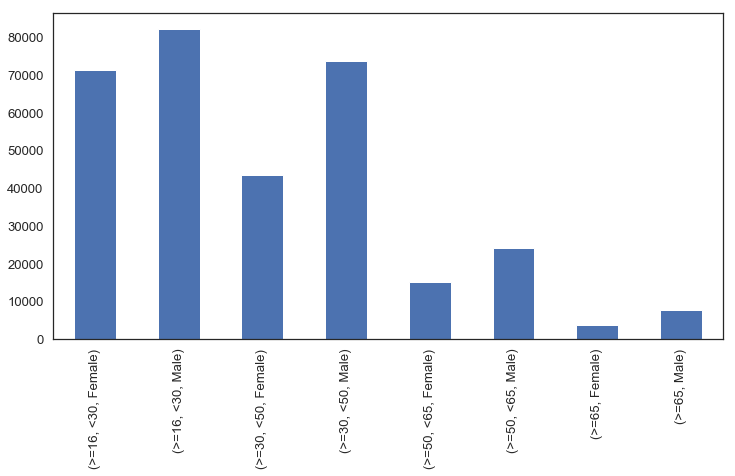

In [19]:
groups = users_v2.groupby(["age_range", "gender"]).size()
groups

sns.set(style="white", font_scale=1.2)
# plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))
groups.plot.bar()
plt.xlabel("")
# plt.savefig("fig/chart22.pdf", bbox_inches = 'tight', dpi=300)

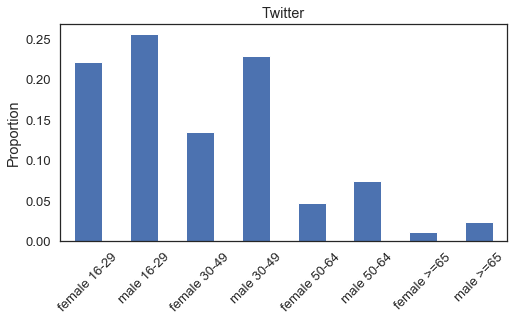

In [20]:
cen = {
    "category": ["female 16-29", "male 16-29", 
                 "female 30-49", "male 30-49", 
                 "female 50-64", "male 50-64", 
                 "female >=65", "male >=65"],
    "n": [
          groups[">=16, <30"]["Female"], groups[">=16, <30"]["Male"],
          groups[">=30, <50"]["Female"], groups[">=30, <50"]["Male"],
          groups[">=50, <65"]["Female"], groups[">=50, <65"]["Male"], 
          groups[">=65"]["Female"], groups[">=65"]["Male"] 
        ]
}
cen = pd.DataFrame(cen).set_index("category")
cen["percent"] = cen / cen.sum()
plt.figure(figsize=(8, 4))
cen["percent"].plot.bar()
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Proportion")
plt.title("Twitter")
plt.savefig("fig/chart22-twitter.pdf", dpi=300, bbox_inches = 'tight')

In [7]:
users = []

import unicodedata

def normalize_spanish(text):
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode().lower()

for line in tqdm(open("disk/user_profile/02-07-image.txt")):
    d = json.loads(line.strip())
    if in_Argentina(d):
        users.append({"uid": d["id"]})
    face = d["faces"][0]
    # print(face)
    age = face['attributes']["age"]["value"]
    gender = face['attributes']["gender"]["value"]
    users.append({"uid": d["id"], "age": age, "gender": gender})
        
users = pd.DataFrame(users).set_index("uid")
users = users[~users.index.duplicated(keep='first')]
len(users)

843686

In [ ]:
users.to_pickle("disk/user_profile/02-07-users-in-Argentina.pl")

In [4]:
users = []

import unicodedata

def normalize_spanish(text):
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode().lower()

for line in tqdm(open("disk/user_profile/02-07-all.txt")):
    d = json.loads(line.strip())
    if in_Argentina(d):
        users.append({"uid": d["id"]})
        
users = pd.DataFrame(users).set_index("uid")
users = users[~users.index.duplicated(keep='first')]
len(users)

2828197

In [6]:
users.to_pickle("disk/user_profile/02-07-users-in-Argentina.pl")

In [63]:
users = []

for line in tqdm(open("disk/user_profile/02-07-all.txt")):
    d = json.loads(line.strip())
    users.append({"uid": d["id"], "location": get_country(d)})
        
users = pd.DataFrame(users).set_index("uid")
users = users[~users.index.duplicated(keep='first')]
len(users)

5600442

In [ ]:
users.location.value_counts()

## 合并两个处理好的文件

In [27]:
users = []

for line in tqdm(open("disk/user_profile/0731-week-image.txt")):
    d = json.loads(line.strip())
    if not outside_Argentina(d):
#     if in_Argentina(d):
        face = d["faces"][0]
        # print(face)
        age = face['attributes']["age"]["value"]
        gender = face['attributes']["gender"]["value"]
        if age >= 16 and age < 30:
            age_range = ">=16, <30"
        elif age >= 30 and age < 50:
            age_range = ">=30, <50"
        elif age >= 50 and age < 65:
            age_range = ">=50, <65"
        elif age >= 65:
            age_range = ">=65"
        users.append({"uid": d["id"], "age": age, "gender": gender, "age_range": age_range})  

for line in tqdm(open("disk/user_profile/02-07-image.txt")):
    d = json.loads(line.strip())
    if not outside_Argentina(d):
#     if in_Argentina(d):
        face = d["faces"][0]
        # print(face)
        age = face['attributes']["age"]["value"]
        gender = face['attributes']["gender"]["value"]
        if age >= 16 and age < 30:
            age_range = ">=16, <30"
        elif age >= 30 and age < 50:
            age_range = ">=30, <50"
        elif age >= 50 and age < 65:
            age_range = ">=50, <65"
        elif age >= 65:
            age_range = ">=65"
        users.append({"uid": d["id"], "age": age, "gender": gender, "age_range": age_range})
        
        
for line in tqdm(open("new_disk/02-10-user-profile-face.lj")):
    d = json.loads(line.strip())
    if not outside_Argentina(d):
#     if in_Argentina(d):
        face = d["faces"][0]
        # print(face)
        age = face['attributes']["age"]["value"]
        gender = face['attributes']["gender"]["value"]
        if age >= 16 and age < 30:
            age_range = ">=16, <30"
        elif age >= 30 and age < 50:
            age_range = ">=30, <50"
        elif age >= 50 and age < 65:
            age_range = ">=50, <65"
        elif age >= 65:
            age_range = ">=65"
        users.append({"uid": d["id"], "age": age, "gender": gender, "age_range": age_range})
        
        
users = pd.DataFrame(users).set_index("uid")
users = users[~users.index.duplicated(keep='first')]

In [28]:
users

,age,age_range,gender
uid,,,
3754809437,53,">=50, <65",Female
2564582235,34,">=30, <50",Male
3252079467,50,">=50, <65",Female
510764754,43,">=30, <50",Female
3082038490,29,">=16, <30",Male
4582409325,41,">=30, <50",Male
172467425,40,">=30, <50",Male
2657714564,73,>=65,Male
1901219448,25,">=16, <30",Female


In [29]:
users.to_pickle("disk/user_profile/02-10-union-users.pl") # not outside Argentina